# Case Study 2: Linear Regressions in Real World


## Outliers

https://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors

In [589]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = 16, 10

from sklearn import linear_model, datasets

In [601]:
n_samples = 1000
n_outliers = 30


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
y[-n_outliers:] = 40 + 10 * np.random.normal(size=(n_outliers))
X[-n_outliers:] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))


In [606]:
# lr = linear_model.LinearRegression()
lr = linear_model.RANSACRegressor()
lr.fit(X, y)

RANSACRegressor()

In [607]:
# Predict data of estimated models
line_X = np.arange(X.min(), X.max(), step=0.1)[:, np.newaxis]
line_y = lr.predict(line_X)

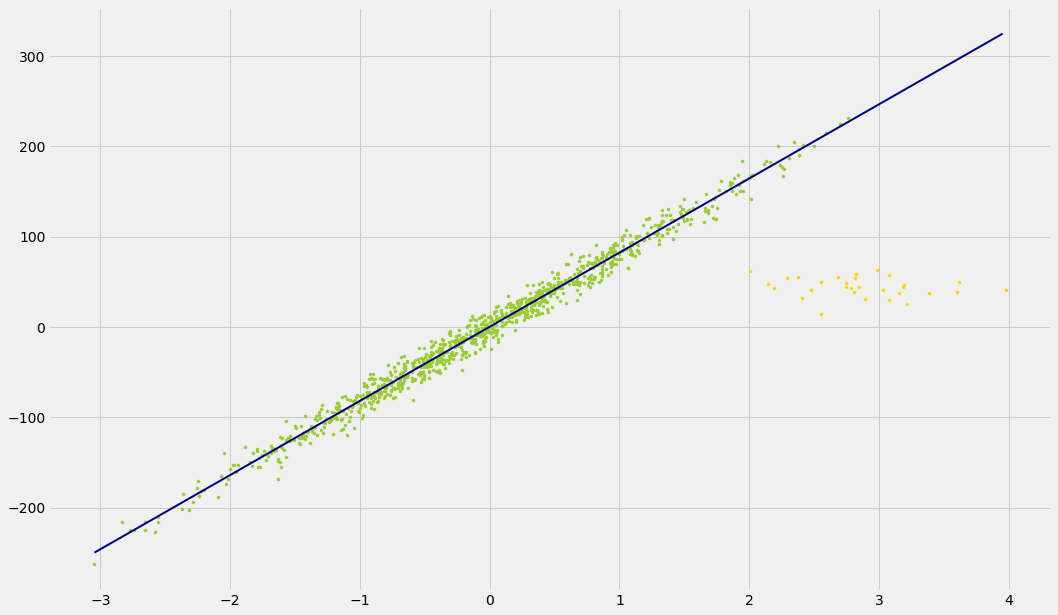

In [608]:
plt.scatter(X[:-n_outliers], y[:-n_outliers], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[-n_outliers:], y[-n_outliers:], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=2, label='Linear regressor')

_Main idea:_ find outliers based on the differences between the model's prediction and the target variable. For classification we can use model confidences.

## Salary prediction

[Common pitfalls in the interpretation of coefficients of linear models](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)

In [783]:
import pandas as pd
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

In [784]:
print(survey['DESCR'])

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Determinants of Wages from the 1985 Current Population Survey

Summary:
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. We wish to determine (i) whether wages are related to these characteristics and (ii) whether there is a gender gap in wages.
Based on residual plots, wages were log-transformed to stabilize the variance. Age and work experience were almost perfectly correlated (r=.98). Multiple regression of log wages against sex, age, years of education, work experience, union membership, southern residence, and occupational status showed that these covariates were related to wages (pooled F test, 

In [613]:
data = survey['frame']

Our goal is to predict Wage (dollars per hour) based on features like education, geo, race, age, experience, etc.

Our plan:
* encode categorical features by using:
   * [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
   * [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)
* normalize features
* scale target variable
* interpretation of coefficients

In [614]:
data

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,5.10,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,4.95,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,6.67,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,4.00,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,7.50,35.0,White,Other,Other,Married
...,...,...,...,...,...,...,...,...,...,...,...
529,18.0,no,male,5.0,not_member,11.36,29.0,White,Professional,Other,Unmarried
530,12.0,no,female,33.0,not_member,6.10,51.0,Other,Professional,Other,Married
531,17.0,no,female,25.0,member,23.25,48.0,Other,Professional,Other,Married
532,12.0,yes,male,13.0,member,19.88,31.0,White,Professional,Other,Married


In [617]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    float64 
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(4)
memory usage: 21.4 KB


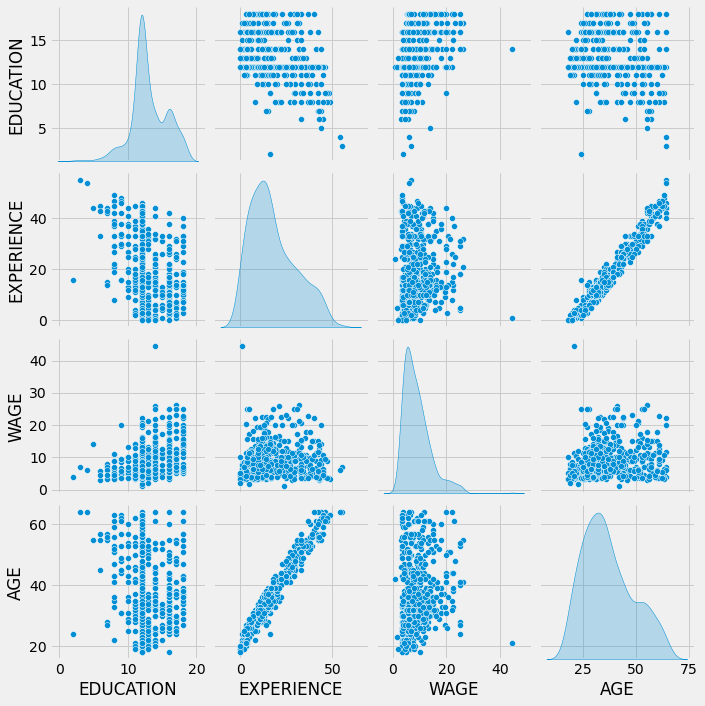

In [616]:
sns.pairplot(data, diag_kind='kde')

In [712]:
data.corr()

,EDUCATION,EXPERIENCE,WAGE,AGE
EDUCATION,1.000000,-0.352676,0.381922,-0.150019
EXPERIENCE,-0.352676,1.000000,0.087060,0.977961
WAGE,0.381922,0.087060,1.000000,0.176967
AGE,-0.150019,0.977961,0.176967,1.000000


In [ ]:
sns.distplot(np.log1p(data['WAGE'])) # we can use log transformation to scale target

In [787]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Binarizer

In [788]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data[survey.feature_names],
    data['WAGE'], test_size=0.33, random_state=42
)

In [789]:
categorical_features = [
 'SOUTH',
 'SEX',
 'UNION',
 'RACE',
 'OCCUPATION',
 'SECTOR',
 'MARR']

numerical_features = [
#     'AGE', #  is highly correlated with EXPERIENCE
    'EXPERIENCE',
    'EDUCATION',
]

In [790]:
from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [769]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), categorical_features), # encode categorical features as a combination of binary features
        (StandardScaler(), numerical_features), # scale numerical features by removing the mean and scaling to unit variance.
        remainder='passthrough',
        verbose_feature_names_out=False   
  
    ),
    Ridge(0.02)
)

In [775]:
model.fit(X_train[categorical_features+numerical_features], np.log1p(y_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])],
                                   verbose_feature_names_out=False)),
                ('ridge', Ridge(alpha=0.02))])

In [792]:
sorted(list(zip(model[0].get_feature_names_out(), model[-1].coef_)), key=lambda x: x[1], reverse=True)

[('OCCUPATION_Management', 0.19255609023678755),
 ('OCCUPATION_Professional', 0.1453081070178786),
 ('UNION_member', 0.10949478009477265),
 ('SEX_male', 0.09872926476056643),
 ('RACE_White', 0.05910774734292297),
 ('EDUCATION', 0.04454827654642061),
 ('SECTOR_Construction', 0.04382654705174199),
 ('SECTOR_Manufacturing', 0.030273142904994714),
 ('SOUTH_no', 0.02891957367064218),
 ('MARR_Married', 0.018811259425087722),
 ('EXPERIENCE', 0.008571468059815054),
 ('OCCUPATION_Clerical', -0.0082294510860728),
 ('MARR_Unmarried', -0.01881125942495718),
 ('RACE_Other', -0.026625065992760266),
 ('SOUTH_yes', -0.02891957367061676),
 ('RACE_Hispanic', -0.03248268135022979),
 ('SECTOR_Other', -0.07409968995558858),
 ('OCCUPATION_Sales', -0.07623250203170108),
 ('OCCUPATION_Other', -0.0837805351007314),
 ('SEX_female', -0.09872926476053416),
 ('UNION_not_member', -0.10949478009478524),
 ('OCCUPATION_Service', -0.16962170903791243)]

In [778]:
preds = model.predict(X_test[categorical_features+numerical_features])

In [766]:
from sklearn.metrics import mean_absolute_error

In [780]:
# numerical (normalized) + categorical features + regularization + target scaling
mean_absolute_error(y_test, np.expm1(preds))

3.144048038089633

In [767]:
# numerical (normalized) + categorical features + regularization
mean_absolute_error(y_test, preds)

3.188035829431019

In [736]:
# numerical (normalized) + categorical features
mean_absolute_error(y_test, preds)

3.1716737288135595

In [697]:
# numerical + categorical features
mean_absolute_error(y_test, preds)

3.187791311741618

In [682]:
# only categorical features
mean_absolute_error(y_test, preds)

3.391398305084746

In [644]:
# only numerical features
mean_absolute_error(y_test, preds)

3.565588638466904

In [655]:
#baseline
np.abs(y_test - y_train.mean()).mean()

4.252824542246278

---

Additinonal:

* [Poisson regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html)
* [Effect of transforming the targets in regression model](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)